## Distributed Computing Final Project File

### Authors: Clarence Williams, Lingzhen Zhu, Ethan Nelson

### 1. Data Import & Pre-Processing (2 pts)

#### 1a. Data Importing
* Our data comes from the nfl_data_py package. First, we import the package to access the data.

In [1]:
import nfl_data_py as nfl

In [2]:
years = []

# loop through years from 2000 to 2023
for i in range(2000,2024):
    years.append(i)

# removing game_date, removing time
# play_type is the predictor col
cols = ["home_team", "away_team", "season_type", "week", "posteam", "posteam_type", 
        "defteam", "side_of_field", "yardline_100", "quarter_seconds_remaining", 
        "half_seconds_remaining", "game_seconds_remaining" , "game_half", "down", 
        "drive", "qtr",  "ydstogo", "play_type", "posteam_timeouts_remaining", 
        "defteam_timeouts_remaining", "posteam_score", "defteam_score", "score_differential", 
        "ep", "epa", "season"]

#TODO add weather to col

data = nfl.import_pbp_data(years, downcast=False, cache=False, alt_path=None)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


In [3]:
# get the desired columns
reduced_data = data.filter(items=cols) 

In [4]:
# select only where there are 4th downs
forth_down = reduced_data.query("down==4.0")

In [15]:
# get counts for play types by season
eda_data = forth_down.groupby(["season", "play_type"])['play_type'].count().reset_index(name='total_count')
eda_data = eda_data.sort_values(by=["season","total_count"], ascending=False)
eda_data

season   play_type  total_count
139    2023        punt         2352
136    2023  field_goal         1037
138    2023        pass          525
141    2023         run          308
137    2023     no_play          253
..      ...         ...          ...
3      2000        punt         2579
0      2000  field_goal          869
2      2000        pass          291
1      2000     no_play          208
4      2000         run          179

[142 rows x 3 columns]

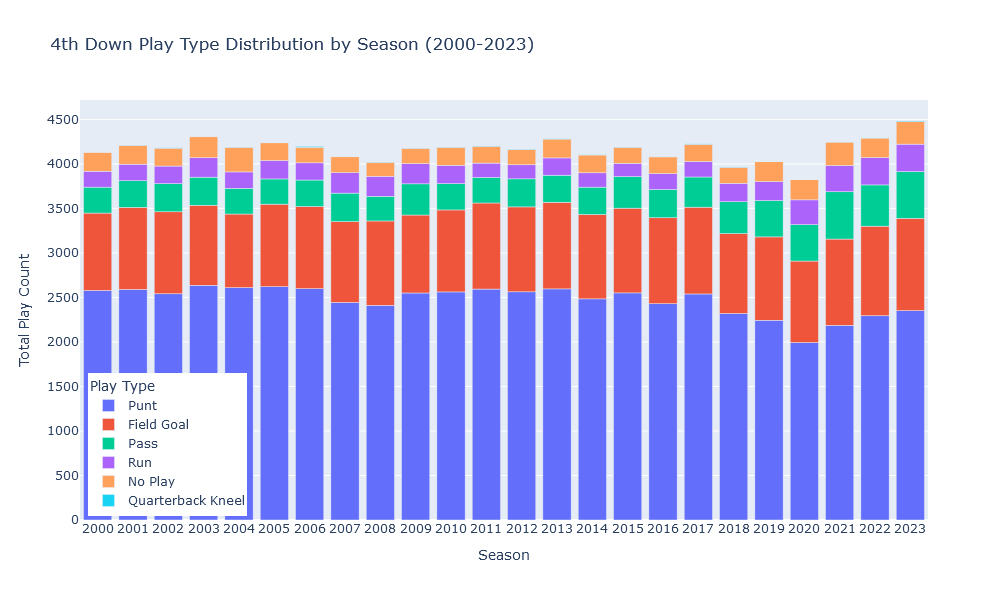

In [16]:
import plotly.express as px

# visualize with plotly
type_mapping = {
    "punt": "Punt",
    "no_play": "No Play",
    "run": "Run",
    None: "Unknown",
    "field_goal": "Field Goal",
    "pass": "Pass",
    "qb_kneel": "Quarterback Kneel"
}
eda_data['play_type'] = eda_data['play_type'].map(type_mapping)

fig = px.bar(eda_data, x="season", y="total_count", color="play_type", title="4th Down Play Type Distribution by Season (2000-2023)", width=1200, height=600)

fig.update_xaxes(
    tickmode='array',
    tickvals=years,  # Specify the desired tick values
    ticktext=years, # Specify the corresponding labels
)

# '''
fig.update_layout(
    legend_title_text="Play Type",
    legend=dict(
            yanchor="bottom",
            y=0.01,
            xanchor="left",
            x=0.01
        ),
    xaxis_title = 'Season',
    yaxis_title = 'Total Play Count'
)
# '''

fig.show()


In [17]:
forth_down["play_type"].unique()

array(['punt', 'no_play', 'run', None, 'field_goal', 'pass', 'qb_kneel'],
      dtype=object)

In [18]:
#forth_down.to_csv('forth_down_3.csv', index=False)
forth_down.shape

(100225, 26)

#### 1b. Create spark dataframe for 4th down data

In [19]:
from pyspark.sql import SparkSession

# set up the session
spark = SparkSession.builder.getOrCreate()

# Convert to PySpark DataFrame
spark_df = spark.createDataFrame(forth_down)
#spark_df = spark.createDataFrame(reduced_data)

# Show the PySpark DataFrame
#spark_df.show(5)

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/01 23:19:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [20]:
spark_df.groupBy("play_type").count().show()
#spark_df["play_type"].distinct()

24/12/01 23:20:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/01 23:20:45 WARN TaskSetManager: Stage 0 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|22437|
|      null|  226|
|   no_play| 4912|
|  qb_kneel|   75|
|       run| 5034|
|      punt|59290|
|      pass| 8251|
+----------+-----+



#### 1c. Removing records with null plays

In [21]:
from pyspark.sql.functions import col

spark_df = spark_df.where(col("play_type").isNotNull())

spark_df.groupBy("play_type").count().show()

24/12/01 23:21:06 WARN TaskSetManager: Stage 3 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|22437|
|   no_play| 4912|
|  qb_kneel|   75|
|       run| 5034|
|      punt|59290|
|      pass| 8251|
+----------+-----+



#### 1d. Removing records with qb_kneel on 4th down

In [22]:
spark_df = spark_df.where(col("play_type") != "qb_kneel")

spark_df.groupBy("play_type").count().show()

24/12/01 23:31:24 WARN TaskSetManager: Stage 6 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|22437|
|   no_play| 4912|
|       run| 5034|
|      punt|59290|
|      pass| 8251|
+----------+-----+



### 2. Data Splitting / Sampling (1 Point)

#### 2a. Actual Split

In [23]:
# out sampling fractions
fractions = {
    "field_goal": 0.6,
    "no_play": 0.6,
    "run": 0.6,
    "punt": 0.4,
    "pass": 0.6
}

# get the sample
train_df = spark_df.sampleBy("play_type", fractions=fractions, seed=42)

# remove sample to form the test
test_df = spark_df.subtract(train_df)

In [24]:
# get the counts per play for train
train_df.groupBy("play_type").count().show()

24/12/01 23:32:15 WARN TaskSetManager: Stage 9 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|13648|
|   no_play| 3000|
|       run| 3062|
|      punt|23643|
|      pass| 4968|
+----------+-----+



In [25]:
# get the counts per play for test
test_df.groupBy("play_type").count().show()

24/12/01 23:32:35 WARN TaskSetManager: Stage 12 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.


24/12/01 23:32:35 WARN TaskSetManager: Stage 13 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 8789|
|   no_play| 1912|
|       run| 1972|
|      punt|35647|
|      pass| 3283|
+----------+-----+



In [26]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half",
            "play_type", "season"]
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx"]
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx"]
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec"]


#### 2b. Under sample majority class (punt)

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN


# Convert PySpark DataFrame to pandas DataFrame
pandas_df = train_df.toPandas()


# Undersample the data
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)


X_resampled, y_resampled = rus.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])

pandas_df.drop("play_type", axis=1, inplace=True)

# Convert back to PySpark DataFrame
undersampled_df = spark.createDataFrame(pd.DataFrame(X_resampled, columns=pandas_df.columns).assign(play_type=y_resampled))
undersampled_df.groupBy("play_type").count().show()

24/12/02 00:51:00 WARN TaskSetManager: Stage 26 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|13648|
|   no_play| 3000|
|      pass| 4968|
|      punt| 3000|
|       run| 3062|
+----------+-----+



#### 2c. Under sample majority class (field goal)

In [31]:
# Convert PySpark DataFrame to pandas DataFrame
pandas_df = undersampled_df.toPandas()


# Undersample the data
rus2 = RandomUnderSampler(sampling_strategy='majority', random_state=42)


X_resampled, y_resampled = rus2.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])

pandas_df.drop("play_type", axis=1, inplace=True)

# Convert back to PySpark DataFrame
undersampled_df2 = spark.createDataFrame(pd.DataFrame(X_resampled, columns=pandas_df.columns).assign(play_type=y_resampled))
undersampled_df2.groupBy("play_type").count().show()

+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 3000|
|   no_play| 3000|
|      pass| 4968|
|      punt| 3000|
|       run| 3062|
+----------+-----+



#### 2d. Oversample all classes but pass

In [32]:
str_col2 = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "season"]

# Convert PySpark DataFrame to pandas DataFrame
pandas_df = undersampled_df2.toPandas()
pandas_df2 = pandas_df.copy()
pandas_df2.drop("play_type", axis=1, inplace=True)
print(pandas_df2.columns)
categorical_indices = [pandas_df2.columns.get_loc(col) for col in str_col2]

print(categorical_indices)


# Define SMOTENC with indices of categorical columns
smote_enn = SMOTENC(categorical_features=categorical_indices, random_state=42)
#X_resampled, y_resampled = rus.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])
X_resampled, y_resampled = smote_enn.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])
pandas_df.drop("play_type", axis=1, inplace=True)

# Convert back to PySpark DataFrame
undersampled_df3 = spark.createDataFrame(pd.DataFrame(X_resampled, columns=pandas_df.columns).assign(play_type=y_resampled))
undersampled_df3.groupBy("play_type").count().show()

Index(['home_team', 'away_team', 'season_type', 'week', 'posteam',
       'posteam_type', 'defteam', 'side_of_field', 'yardline_100',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'down', 'drive', 'qtr',
       'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'posteam_score', 'defteam_score', 'score_differential', 'ep', 'epa',
       'season'],
      dtype='object')
[0, 1, 2, 4, 5, 6, 7, 12, 24]
+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 4968|
|   no_play| 4968|
|      pass| 4968|
|      punt| 4968|
|       run| 4968|
+----------+-----+



### 3. Exploratory Data Analysis (2 Points)

In [33]:
# We can look at the undesampled_v3 playbook 
undersampled_df3.columns

['home_team',
 'away_team',
 'season_type',
 'week',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'down',
 'drive',
 'qtr',
 'ydstogo',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'ep',
 'epa',
 'season',
 'play_type']

#### 3a. Yards to Go

In [34]:
# histrogram of yards to go
yrdstogo = undersampled_df3.select('ydstogo').toPandas()

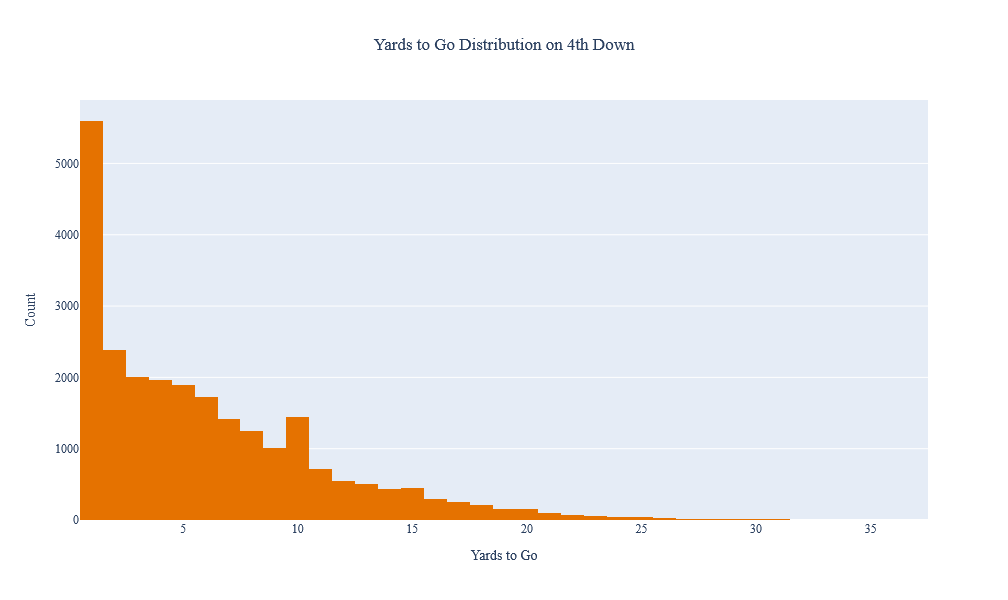

In [35]:
fig = px.histogram(
    yrdstogo['ydstogo'],
    nbins = 46,
    color_discrete_sequence = ['#E57200'],
    title = 'Yards to Go Distribution on 4th Down',
    width = 1000,
    height = 600
)

fig.update_layout(
    xaxis_title = 'Yards to Go',
    yaxis_title = 'Count',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman'
)

fig.show()

#### 3b. Yardline

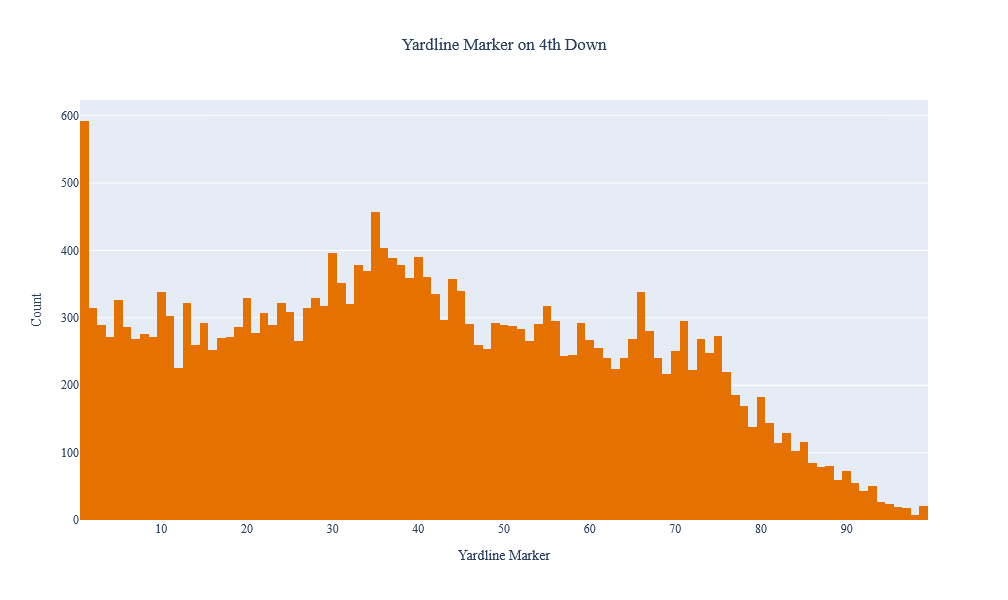

In [36]:
# histrogram of yards to go
yardline_100 = undersampled_df3.select('yardline_100').toPandas()

fig = px.histogram(
    yardline_100['yardline_100'],
    nbins = 100,
    color_discrete_sequence = ['#E57200'],
    title = 'Yardline Marker on 4th Down',
    width = 1000,
    height = 600
)

fig.update_layout(
    xaxis_title = 'Yardline Marker',
    yaxis_title = 'Count',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman'
)

fig.show()

#### 3c. Yards to Go and Play Type

In [37]:
import numpy as np

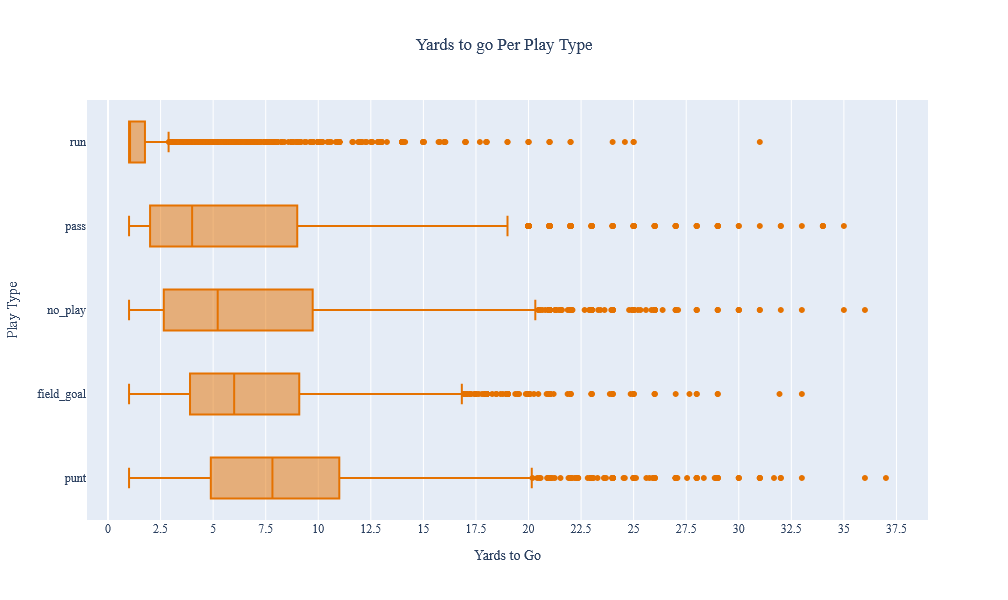

In [38]:
# histrogram of yards to go
df = undersampled_df3.select(['play_type', 'ydstogo']).toPandas()

fig = px.box(
    x = df['ydstogo'],
    y = df['play_type'],
    color_discrete_sequence = ['#E57200'],
    title = 'Yards to go Per Play Type',
    width = 1000,
    height = 600
)

fig.update_layout(
    yaxis_title = 'Play Type',
    xaxis_title = 'Yards to Go',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman',
    xaxis_tickvals = np.arange(50, step = 2.5),
    yaxis_categoryorder = 'mean descending'
)


fig.show()

#### 3d. 

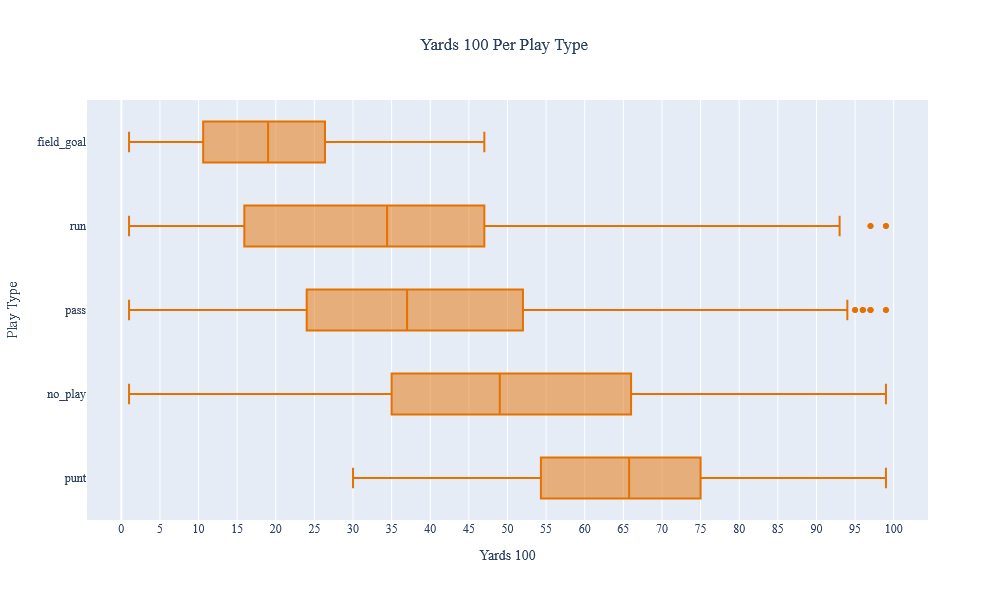

In [39]:
# histrogram of yards to go
df = undersampled_df3.select(['play_type', 'yardline_100']).toPandas()

fig = px.box(
    x = df['yardline_100'],
    y = df['play_type'],
    color_discrete_sequence = ['#E57200'],
    title = 'Yards 100 Per Play Type',
    width = 1000,
    height = 600
)

fig.update_layout(
    yaxis_title = 'Play Type',
    xaxis_title = 'Yards 100',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman',
    xaxis_tickvals = np.arange(105, step = 5),
    yaxis_categoryorder = 'mean descending'
)


fig.show()

### 4. Model Construction (3 Points)

In [40]:
import warnings
warnings.filterwarnings("ignore")

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MaxAbsScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
# Stage 1: Process categorical features with StringIndexer
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# Stage 2: Encode indexed features with OneHotEncoder
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec)

# Stage 3: Assemble features into a single vector
va = VectorAssembler(inputCols=ohe_col_vec, outputCol="features")

# Stage 4: Normalize feature values using MaxAbsScaler
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

In [42]:
# Stage 5: Use Random Forest Classifier
rf = RandomForestClassifier(labelCol='play_type_idx', 
                             featuresCol='scaledFeatures', 
                             seed=42)

# Combine stages into a pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, rf])

# Set up hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 50, 100])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .addGrid(rf.impurity, ["gini", "entropy"])\
    .build()

# Set up evaluator for precision
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="precisionByLabel"
)

# Set up TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8  # 80% training, 20% validation
)

# Train model
model = tvs.fit(undersampled_df3)

24/12/02 02:40:30 WARN DAGScheduler: Broadcasting large task binary with size 1160.0 KiB
24/12/02 02:40:30 WARN DAGScheduler: Broadcasting large task binary with size 1352.1 KiB
24/12/02 02:40:33 WARN DAGScheduler: Broadcasting large task binary with size 1041.9 KiB
24/12/02 02:40:33 WARN DAGScheduler: Broadcasting large task binary with size 1229.6 KiB
24/12/02 02:40:34 WARN DAGScheduler: Broadcasting large task binary with size 1435.4 KiB
24/12/02 02:40:40 WARN DAGScheduler: Broadcasting large task binary with size 1255.3 KiB
24/12/02 02:40:41 WARN DAGScheduler: Broadcasting large task binary with size 1693.9 KiB
24/12/02 02:40:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/12/02 02:40:41 WARN DAGScheduler: Broadcasting large task binary with size 1602.5 KiB
24/12/02 02:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB
24/12/02 02:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1796.5 KiB
24/12/02 02:40:44 WARN D

24/12/02 02:41:19 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


24/12/02 02:41:20 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


24/12/02 02:41:22 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


24/12/02 02:41:24 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
24/12/02 02:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1093.3 KiB
24/12/02 02:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1656.2 KiB
24/12/02 02:41:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/12/02 02:41:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/12/02 02:41:28 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/12/02 02:41:29 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/12/02 02:41:30 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
24/12/02 02:41:31 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


24/12/02 02:41:32 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


24/12/02 02:41:33 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


24/12/02 02:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB


24/12/02 02:41:35 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
24/12/02 02:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
24/12/02 02:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1704.5 KiB
24/12/02 02:41:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/12/02 02:41:40 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/12/02 02:41:40 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/12/02 02:41:41 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


24/12/02 02:41:42 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


24/12/02 02:41:43 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


24/12/02 02:41:45 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


24/12/02 02:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1031.7 KiB


24/12/02 02:41:46 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


24/12/02 02:41:47 WARN DAGScheduler: Broadcasting large task binary with size 1131.2 KiB


In [43]:
# Extract best model
best_model = model.bestModel
print("Tuned Parameters of the Best Model:")
for stage in best_model.stages:
    if isinstance(stage, RandomForestClassifier):
        print(stage.explainParams())

# Make predictions on test data
predictions = best_model.transform(test_df)

# Evaluate performance
precision = evaluator.evaluate(predictions)
print(f"Precision: {precision}")

# Distribution of predictions in the test set
print("Distribution of Predictions (Class Names):")
predictions.groupBy("play_type").count().show()

print("Distribution of Predictions (Class Indices):")
predictions.groupBy("play_type_idx").count().show()

Tuned Parameters of the Best Model:
24/12/02 02:42:39 WARN TaskSetManager: Stage 658 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 02:42:39 WARN TaskSetManager: Stage 659 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.


24/12/02 02:42:41 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


Precision: 0.37767050123253904
Distribution of Predictions (Class Names):
24/12/02 02:42:42 WARN TaskSetManager: Stage 668 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 02:42:43 WARN TaskSetManager: Stage 669 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 8789|
|   no_play| 1912|
|       run| 1972|
|      punt|35647|
|      pass| 3283|
+----------+-----+

Distribution of Predictions (Class Indices):
24/12/02 02:42:44 WARN TaskSetManager: Stage 682 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 02:42:44 WARN TaskSetManager: Stage 683 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0| 8789|
|          1.0| 1912|
|          4.0| 1972|
|    

24/12/02 02:42:54 WARN TaskSetManager: Stage 696 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 02:42:55 WARN TaskSetManager: Stage 697 contains a task of very large size (2034 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 02:42:56 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


24/12/02 02:42:58 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


24/12/02 02:42:59 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


24/12/02 02:43:00 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


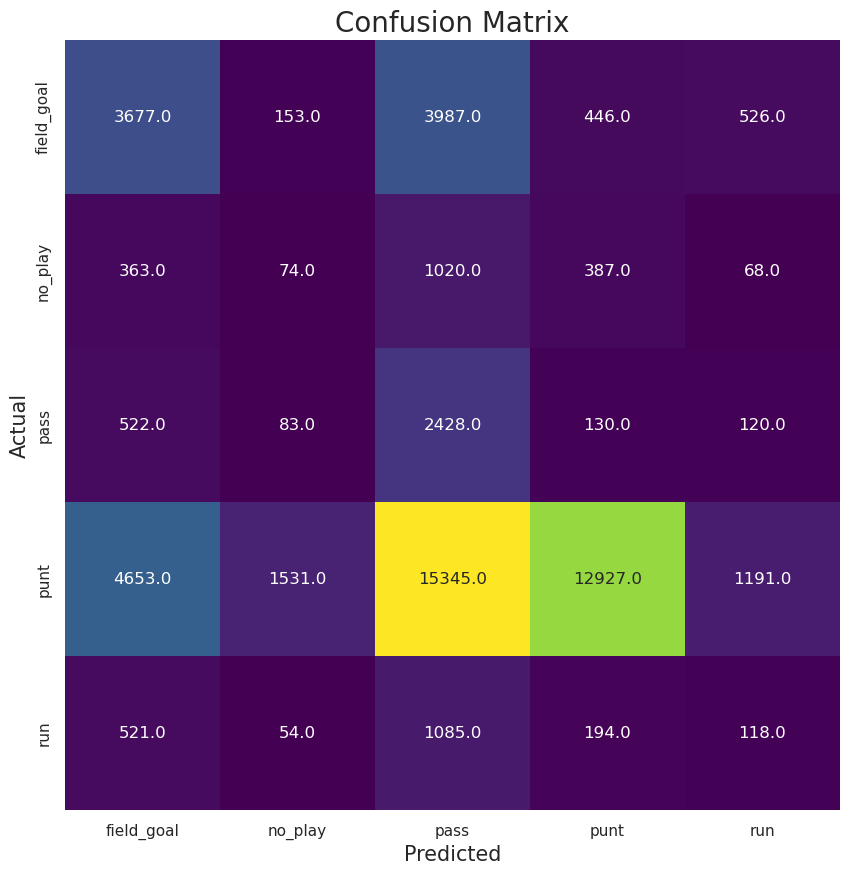

In [44]:
# Confusion Matrix
preds_and_labels = predictions.select(['prediction', 'play_type_idx'])\
                               .withColumn('play_type_idx', col('play_type_idx').cast(FloatType()))\
                               .orderBy('prediction')

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
conf_matrix = metrics.confusionMatrix().toArray()

# Visualize Confusion Matrix
labels = ["field_goal", "no_play", "pass", "punt", "run"]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(conf_matrix,
                 cmap='viridis',
                 annot=True, fmt='0',
                 cbar=False, 
                 xticklabels=labels,
                 yticklabels=labels)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.show()